In [27]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig

zsh:1: command not found: apt-get


In [28]:
!pip install -e ~/Desktop/FinRL # Change this to your FinRL path

Obtaining file:///Users/gabe7430/Desktop/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/d8/ssnt8fpj2dsc5bxlzwprcmlc0000gn/T/pip-install-7zg6zdda/elegantrl_5b17ca0c8d27422aab87ca3e8f0a47d8
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/d8/ssnt8fpj2dsc5bxlzwprcmlc0000gn/T/pip-install-7zg6zdda/elegantrl_5b17ca0c8d27422aab87ca3e8f0a47d8
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl size=9095 sha256=602d267f76a4721808cf85cebbc30

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_stock_trading.env_stocktrading_stacking import StockTradingStackingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent, DRLStackingAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
import itertools

In [43]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-11-10'
TEST_START_DATE = '2023-11-11'
TEST_END_DATE = '2024-11-11'


INDICATORS = ['macd',
              'rsi_30',
              'cci_30',
              'dx_30']

In [44]:
if False:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed.to_csv("datasets/processed.csv", index=False)

In [45]:
processed = pd.read_csv("datasets/processed.csv")

In [46]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + 5 * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 56


In [47]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [48]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

stacking_agent = DRLStackingAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [49]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

timesteps_dict = {'model_6' : 10000}

Check if able to create a stacking agent. Can skip this line below if already able to.

In [23]:
df_summary = stacking_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)


Evaluating 2024 (2024-01-01 to 2024-11-30)
Test data shape: (0, 13)


KeyError: 0

In [ ]:
df_summary = stacking_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)

<a id='6'></a>
# Backtest Our Strategy

Set up and Parameters

In [ ]:
# Store results for each window
results_dict = {}

# Parameters for all runs
rebalance_window = 63
validation_window = 63
A2C_model_kwargs = {
    'n_steps': 5,
    'ent_coef': 0.005,
    'learning_rate': 0.0007
}
timesteps_dict = {'model_6': 10000}

2020 Evaluation

In [52]:
print("\nEvaluating 2020 period")
window_name = "2020"
start_date = "2020-01-01"
end_date = "2020-12-31"

try:
    window_agent = DRLStackingAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, start_date),
        val_test_period=(start_date, end_date),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )
    
    df_summary = window_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)
    results_dict[window_name] = df_summary
    
    if 'account_value' in df_summary.columns:
        returns = df_summary['account_value'].pct_change()
        total_return = (df_summary['account_value'].iloc[-1] / df_summary['account_value'].iloc[0]) - 1
        annual_return = total_return * (252 / len(df_summary))
        sharpe = (252 ** 0.5) * returns.mean() / returns.std()
        
        print("\n2020 Summary statistics:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Annual Return: {annual_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        
        # Plot 2020 results
        plt.figure(figsize=(15, 8))
        
        # Calculate normalized returns
        initial_value = df_summary['account_value'].iloc[0]
        normalized_value = (df_summary['account_value'] / initial_value) - 1
        
        plt.plot(df_summary.index, normalized_value, label='Portfolio Return', color='blue')
        plt.title('2020 Portfolio Performance')
        plt.xlabel('Trading Days')
        plt.ylabel('Return (%)')
        plt.grid(True)
        
        # Add performance metrics as text box
        plt.figtext(0.02, 0.02, 
                   f'Total Return: {total_return:.2%}\n'
                   f'Annual Return: {annual_return:.2%}\n'
                   f'Sharpe Ratio: {sharpe:.2f}\n'
                   f'Trading Days: {len(df_summary)}',
                   fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error evaluating 2020: {str(e)}")


Evaluating 2020 period
turbulence_threshold:  48.67615328100142
Error evaluating 2020: [Errno 2] No such file or directory: 'examples/trained_models/PPO_2K_126.zip'


2021 Evaluation

In [ ]:
print("\nEvaluating 2021 period")
window_name = "2021"
start_date = "2021-01-01"
end_date = "2021-12-31"

try:
    window_agent = DRLStackingAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, start_date),
        val_test_period=(start_date, end_date),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )
    
    df_summary = window_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)
    results_dict[window_name] = df_summary
    
    if 'account_value' in df_summary.columns:
        returns = df_summary['account_value'].pct_change()
        total_return = (df_summary['account_value'].iloc[-1] / df_summary['account_value'].iloc[0]) - 1
        annual_return = total_return * (252 / len(df_summary))
        sharpe = (252 ** 0.5) * returns.mean() / returns.std()
        
        print("\n2021 Summary statistics:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Annual Return: {annual_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        
        # Plot 2020 results
        plt.figure(figsize=(15, 8))
        
        # Calculate normalized returns
        initial_value = df_summary['account_value'].iloc[0]
        normalized_value = (df_summary['account_value'] / initial_value) - 1
        
        plt.plot(df_summary.index, normalized_value, label='Portfolio Return', color='blue')
        plt.title('2021 Portfolio Performance')
        plt.xlabel('Trading Days')
        plt.ylabel('Return (%)')
        plt.grid(True)
        
        # Add performance metrics as text box
        plt.figtext(0.02, 0.02, 
                   f'Total Return: {total_return:.2%}\n'
                   f'Annual Return: {annual_return:.2%}\n'
                   f'Sharpe Ratio: {sharpe:.2f}\n'
                   f'Trading Days: {len(df_summary)}',
                   fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error evaluating 2021: {str(e)}")

2022 Evaluation

In [ ]:
print("\nEvaluating 2022 period")
window_name = "2022"
start_date = "2022-01-01"
end_date = "2022-12-31"

try:
    window_agent = DRLStackingAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, start_date),
        val_test_period=(start_date, end_date),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )
    
    df_summary = window_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)
    results_dict[window_name] = df_summary
    
    if 'account_value' in df_summary.columns:
        returns = df_summary['account_value'].pct_change()
        total_return = (df_summary['account_value'].iloc[-1] / df_summary['account_value'].iloc[0]) - 1
        annual_return = total_return * (252 / len(df_summary))
        sharpe = (252 ** 0.5) * returns.mean() / returns.std()
        
        print("\n2022 Summary statistics:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Annual Return: {annual_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        
        # Plot 2020 results
        plt.figure(figsize=(15, 8))
        
        # Calculate normalized returns
        initial_value = df_summary['account_value'].iloc[0]
        normalized_value = (df_summary['account_value'] / initial_value) - 1
        
        plt.plot(df_summary.index, normalized_value, label='Portfolio Return', color='blue')
        plt.title('2022 Portfolio Performance')
        plt.xlabel('Trading Days')
        plt.ylabel('Return (%)')
        plt.grid(True)
        
        # Add performance metrics as text box
        plt.figtext(0.02, 0.02, 
                   f'Total Return: {total_return:.2%}\n'
                   f'Annual Return: {annual_return:.2%}\n'
                   f'Sharpe Ratio: {sharpe:.2f}\n'
                   f'Trading Days: {len(df_summary)}',
                   fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error evaluating 2022: {str(e)}")

2023 Evaluation

In [ ]:
print("\nEvaluating 2023 period")
window_name = "2023"
start_date = "2023-01-01"
end_date = "2023-12-31"

try:
    window_agent = DRLStackingAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, start_date),
        val_test_period=(start_date, end_date),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )
    
    df_summary = window_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)
    results_dict[window_name] = df_summary
    
    if 'account_value' in df_summary.columns:
        returns = df_summary['account_value'].pct_change()
        total_return = (df_summary['account_value'].iloc[-1] / df_summary['account_value'].iloc[0]) - 1
        annual_return = total_return * (252 / len(df_summary))
        sharpe = (252 ** 0.5) * returns.mean() / returns.std()
        
        print("\n2023 Summary statistics:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Annual Return: {annual_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        
        # Plot 2020 results
        plt.figure(figsize=(15, 8))
        
        # Calculate normalized returns
        initial_value = df_summary['account_value'].iloc[0]
        normalized_value = (df_summary['account_value'] / initial_value) - 1
        
        plt.plot(df_summary.index, normalized_value, label='Portfolio Return', color='blue')
        plt.title('2023 Portfolio Performance')
        plt.xlabel('Trading Days')
        plt.ylabel('Return (%)')
        plt.grid(True)
        
        # Add performance metrics as text box
        plt.figtext(0.02, 0.02, 
                   f'Total Return: {total_return:.2%}\n'
                   f'Annual Return: {annual_return:.2%}\n'
                   f'Sharpe Ratio: {sharpe:.2f}\n'
                   f'Trading Days: {len(df_summary)}',
                   fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error evaluating 2023: {str(e)}")

2024 YTD Evaluation

In [ ]:
print("\nEvaluating 2024 YTD period")
window_name = "2024_YTD"
start_date = "2024-01-01"
end_date = "2024-11-11"

try:
    window_agent = DRLStackingAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, start_date),
        val_test_period=(start_date, end_date),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )
    
    df_summary = window_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)
    results_dict[window_name] = df_summary
    
    if 'account_value' in df_summary.columns:
        returns = df_summary['account_value'].pct_change()
        total_return = (df_summary['account_value'].iloc[-1] / df_summary['account_value'].iloc[0]) - 1
        annual_return = total_return * (252 / len(df_summary))
        sharpe = (252 ** 0.5) * returns.mean() / returns.std()
        
        print("\n2024 YTD Summary statistics:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Annual Return: {annual_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        
        # Plot 2020 results
        plt.figure(figsize=(15, 8))
        
        # Calculate normalized returns
        initial_value = df_summary['account_value'].iloc[0]
        normalized_value = (df_summary['account_value'] / initial_value) - 1
        
        plt.plot(df_summary.index, normalized_value, label='Portfolio Return', color='blue')
        plt.title('2024 YTD Portfolio Performance')
        plt.xlabel('Trading Days')
        plt.ylabel('Return (%)')
        plt.grid(True)
        
        # Add performance metrics as text box
        plt.figtext(0.02, 0.02, 
                   f'Total Return: {total_return:.2%}\n'
                   f'Annual Return: {annual_return:.2%}\n'
                   f'Sharpe Ratio: {sharpe:.2f}\n'
                   f'Trading Days: {len(df_summary)}',
                   fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error evaluating 2024 YTD: {str(e)}")

Summary Table

In [ ]:
# Create summary table
summary_data = []
for window_name, df_summary in results_dict.items():
    if 'account_value' in df_summary.columns:
        returns = df_summary['account_value'].pct_change()
        total_return = (df_summary['account_value'].iloc[-1] / df_summary['account_value'].iloc[0]) - 1
        annual_return = total_return * (252 / len(df_summary))
        sharpe = (252 ** 0.5) * returns.mean() / returns.std()
        
        summary_data.append({
            'Window': window_name,
            'Total Return': f"{total_return:.2%}",
            'Annual Return': f"{annual_return:.2%}",
            'Sharpe Ratio': f"{sharpe:.2f}",
            'Trading Days': len(df_summary)
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\nPerformance Summary Across All Windows:")
    print(summary_df.to_string(index=False))

    # Save results
    results_path = os.path.join(RESULTS_DIR, 'stacking_evaluation_results.csv')
    summary_df.to_csv(results_path, index=False)
    print(f"\nResults saved to: {results_path}")


Evaluating 2020 period: 2020-01-01 to 2020-12-31
turbulence_threshold:  48.67615328100142
Error evaluating 2020: [Errno 2] No such file or directory: 'examples/trained_models/PPO_2K_126.zip'

Evaluating 2021 period: 2021-01-01 to 2021-12-31
turbulence_threshold:  54.70300487499424
Error evaluating 2021: [Errno 2] No such file or directory: 'examples/trained_models/PPO_2K_126.zip'

Evaluating 2022 period: 2022-01-01 to 2022-12-31
Stacking Strategy took:  1.5099843343098958e-07  minutes

DataFrame columns: ['Iter', 'Val Start', 'Val End', 'Stacking Model Used']
DataFrame shape: (0, 4)
Successfully evaluated 2022

Evaluating 2023 period: 2023-01-01 to 2023-12-31
Stacking Strategy took:  1.1523564656575521e-07  minutes

DataFrame columns: ['Iter', 'Val Start', 'Val End', 'Stacking Model Used']
DataFrame shape: (0, 4)
Successfully evaluated 2023

Evaluating 2024_YTD period: 2024-01-01 to 2024-11-11
Stacking Strategy took:  6.75519307454427e-08  minutes

DataFrame columns: ['Iter', 'Val Sta

<Figure size 1500x1000 with 0 Axes>

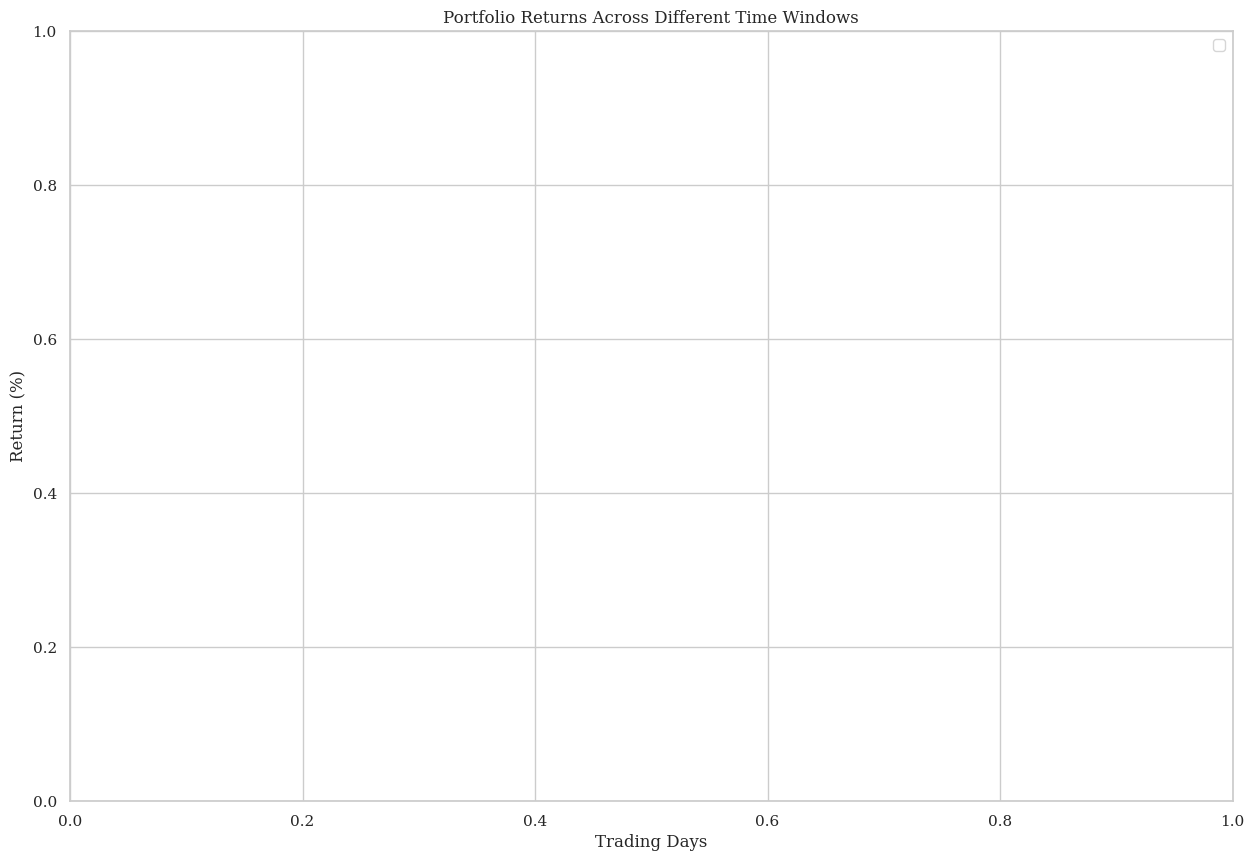

In [51]:
"""
# Define the time windows for evaluation
evaluation_windows = {
    "2020": ("2020-01-01", "2020-12-31"),
    "2021": ("2021-01-01", "2021-12-31"),
    "2022": ("2022-01-01", "2022-12-31"),
    "2023": ("2023-01-01", "2023-12-31"),
    "2024_YTD": ("2024-01-01", "2024-11-11")
}

# Parameters for all runs
rebalance_window = 63
validation_window = 63
A2C_model_kwargs = {
    'n_steps': 5,
    'ent_coef': 0.005,
    'learning_rate': 0.0007
}
timesteps_dict = {'model_6': 10000}

# Store results for each window
results_dict = {}

for window_name, (start_date, end_date) in evaluation_windows.items():
    print(f"\nEvaluating {window_name} period: {start_date} to {end_date}")
    
    try:
        # Create stacking agent for this window
        window_agent = DRLStackingAgent(
            df=processed,
            train_period=(TRAIN_START_DATE, start_date),
            val_test_period=(start_date, end_date),
            rebalance_window=rebalance_window,
            validation_window=validation_window,
            **env_kwargs
        )
        
        # Run strategy for this window
        df_summary = window_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)
        
        # Print DataFrame info to understand its structure
        print("\nDataFrame columns:", df_summary.columns.tolist())
        print("DataFrame shape:", df_summary.shape)
        
        # Store results
        results_dict[window_name] = df_summary
        
        print(f"Successfully evaluated {window_name}")
        
        # Calculate returns if we have account_value column
        if 'account_value' in df_summary.columns:
            returns = df_summary['account_value'].pct_change()
            total_return = (df_summary['account_value'].iloc[-1] / df_summary['account_value'].iloc[0]) - 1
            annual_return = total_return * (252 / len(df_summary))
            sharpe = (252 ** 0.5) * returns.mean() / returns.std()
            
            print("\nSummary statistics:")
            print(f"Total Return: {total_return:.2%}")
            print(f"Annual Return: {annual_return:.2%}")
            print(f"Sharpe Ratio: {sharpe:.2f}")
        
    except Exception as e:
        print(f"Error evaluating {window_name}: {str(e)}")
        continue

# Create visualization
plt.figure(figsize=(15, 10))

for window_name, df_summary in results_dict.items():
    if 'account_value' in df_summary.columns:
        # Normalize to show percentage returns
        initial_value = df_summary['account_value'].iloc[0]
        normalized_value = (df_summary['account_value'] / initial_value) - 1
        plt.plot(df_summary.index, normalized_value, label=f"{window_name}")

plt.title('Portfolio Returns Across Different Time Windows')
plt.xlabel('Trading Days')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.show()

# Create summary table
summary_data = []
for window_name, df_summary in results_dict.items():
    if 'account_value' in df_summary.columns:
        returns = df_summary['account_value'].pct_change()
        total_return = (df_summary['account_value'].iloc[-1] / df_summary['account_value'].iloc[0]) - 1
        annual_return = total_return * (252 / len(df_summary))
        sharpe = (252 ** 0.5) * returns.mean() / returns.std()
        
        summary_data.append({
            'Window': window_name,
            'Total Return': f"{total_return:.2%}",
            'Annual Return': f"{annual_return:.2%}",
            'Sharpe Ratio': f"{sharpe:.2f}",
            'Trading Days': len(df_summary)
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\nPerformance Summary Across All Windows:")
    print(summary_df.to_string(index=False))

    # Save results
    results_path = os.path.join(RESULTS_DIR, 'stacking_evaluation_results.csv')
    summary_df.to_csv(results_path, index=False)
    print(f"\nResults saved to: {results_path}")